/tmp/ipython-input-905527167.py:53: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc_data = yf.download(ticker_symbol, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Data downloaded successfully.

Attempting LPPL fitting with multiple initial guesses...

Trying initial guess set 1/3
Fit successful with cost: 523808226428.34863
This is the best fit so far.

Trying initial guess set 2/3


Fit successful with cost: 523808226107.45105
This is the best fit so far.

Trying initial guess set 3/3
Fit successful with cost: 593064581221.1895

Best Fitted Parameters:
a: 25931.926023935193
b: -5.4221216925559075
tc: 3286.0000000000005
alpha: 0.9999999999999999
omega: 8.439890195043205
phi: -10.198924680642095
Best fit cost (Sum of Squared Residuals): 523808226107.45105

Fitted LPPL Parameters:
a (Expected price at tc): 25931.926023935193
b (Magnitude of the power-law component): -5.4221216925559075
tc (Critical time): 3286.0000000000005
alpha (Power-law exponent): 0.9999999999999999
omega (Oscillation frequency): 8.439890195043205
phi (Phase of oscillations): -10.198924680642095

Confidence Intervals (95%):
a: (25156.0091, 26707.8429)
b: (-11.5389, 0.6947)
tc: (3232.4010, 3339.5990)
alpha: (0.8591, 1.1409)
omega: (8.0687, 8.8111)
phi: (-13.2566, -7.1412)

Interpretation of Parameters:

tc_fit (3286.00): This is the estimated critical time of the potential bubble.
In the context o

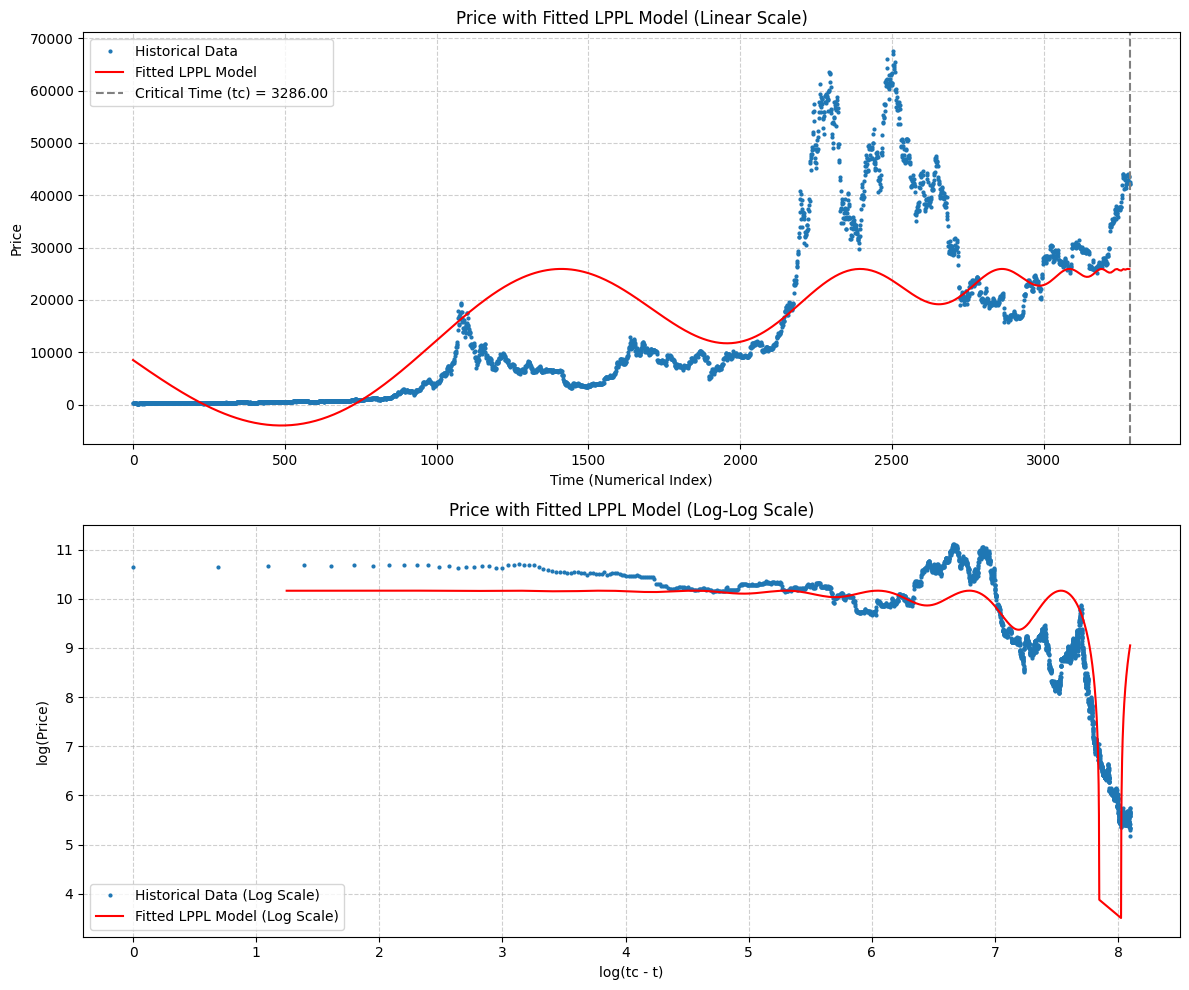

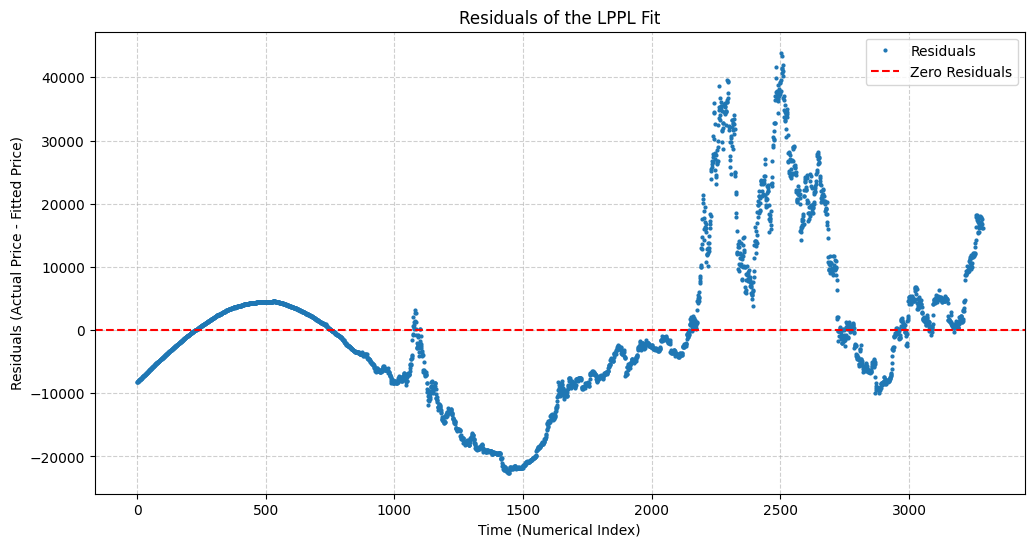

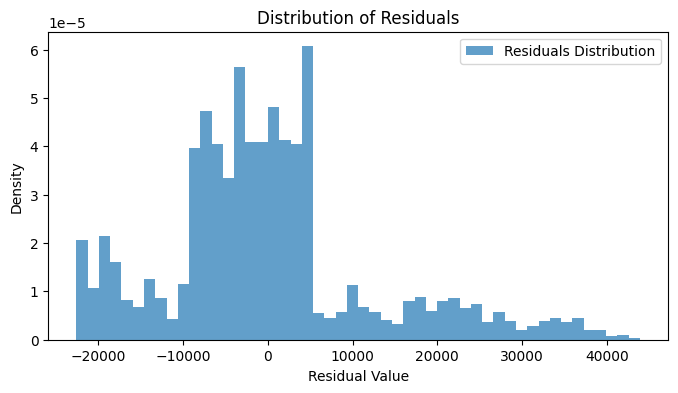


--- Analysis Complete ---


In [25]:
import yfinance as yf
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import warnings

# 1. Define the LPPL model function
def lppl(t, a, b, tc, alpha, omega, phi):
  """
  Log-Periodic Power Law (LPPL) model function.

  Args:
    t: Time (numerical representation - expected to be 1D).
    a, b, tc, alpha, omega, phi: LPPL parameters.

  Returns:
    The LPPL model value at time t (1D array).
  """
  # Ensure t is a NumPy array and 1D
  t = np.asarray(t).flatten()

  # Ensure tc - t is positive before taking the logarithm
  diff = tc - t

  # Initialize result array with NaNs
  result = np.full_like(t, np.nan, dtype=float)

  # Identify valid points where diff > 0
  valid_mask = diff > 0

  # Calculate LPPL only for valid points
  valid_diff = diff[valid_mask]

  # Check if valid_diff is empty to avoid log(0) or log of negative numbers
  if valid_diff.size > 0:
    log_valid_diff = np.log(valid_diff)
    result[valid_mask] = a + b * valid_diff**alpha * (1 + np.cos(omega * log_valid_diff + phi))

  return result

# 2. Fetch financial data
# Define the ticker symbol for the asset
ticker_symbol = 'BTC-USD' # Change this to analyze a different asset

# Define the start and end dates
start_date = '2015-01-01'
end_date = '2023-12-31' # Change these dates as needed

# Download historical data
print(f"Downloading historical data for {ticker_symbol} from {start_date} to {end_date}...")
try:
    btc_data = yf.download(ticker_symbol, start=start_date, end=end_date)
    if btc_data.empty:
        raise ValueError("No data downloaded. Check ticker symbol and date range.")
    print("Data downloaded successfully.")
    # display(btc_data.head())
    # display(btc_data.info())
except Exception as e:
    print(f"Error downloading data: {e}")
    # Exit or handle the error appropriately if data download fails
    exit() # Exiting for this example, you might want different error handling


# 3. Prepare the historical data for fitting
# Extract the 'Close' price and convert the date index to numerical representation
# Ensure btc_data_close is a 1D array and drop potential NaNs
btc_data_close = btc_data['Close'].dropna().values.flatten().astype(float)
if len(btc_data_close) == 0:
    print("Error: No valid closing price data after dropping NaNs.")
    exit() # Exit if no valid data

time_numeric = np.arange(len(btc_data_close)).astype(float) # Ensure time is float

# Get the last closing price as a scalar
last_close_price = float(btc_data_close[-1])

# 4. Implement the LPPL model fitting
# Provide multiple sets of initial guesses to improve robustness
initial_guesses_list = [
    np.array([last_close_price, -100.0, float(len(btc_data_close) + 50), 0.5, 10.0, 0.0], dtype=float),
    np.array([last_close_price, -50.0, float(len(btc_data_close) + 100), 0.8, 5.0, np.pi/2], dtype=float),
    np.array([last_close_price, -200.0, float(len(btc_data_close) + 20), 0.3, 15.0, np.pi], dtype=float),
]

# Set bounds for the parameters
# tc must be greater than the last data point (index)
# alpha must be between 0 and 1
# omega must be positive
bounds_lower = np.array([-np.inf, -np.inf, float(len(btc_data_close)), 0.0, 0.0, -np.inf], dtype=float)
bounds_upper = np.array([np.inf, np.inf, np.inf, 1.0, np.inf, np.inf], dtype=float)
bounds = (bounds_lower, bounds_upper)

best_params = None
best_cost = np.inf

print("\nAttempting LPPL fitting with multiple initial guesses...")

# Iterate through initial guesses
for i, initial_guesses in enumerate(initial_guesses_list):
    print(f"\nTrying initial guess set {i+1}/{len(initial_guesses_list)}")
    try:
        # Suppress RuntimeWarnings for invalid value encountered in log
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=RuntimeWarning)
            params, covariance = curve_fit(
                lppl,
                time_numeric,
                btc_data_close,
                p0=initial_guesses,
                bounds=bounds,
                maxfev=10000
            )

        # Calculate the cost (sum of squared residuals) for this fit
        fitted_values = lppl(time_numeric, *params)
        # Use np.nansum to handle potential NaN values in fitted_values
        cost = np.nansum((btc_data_close - fitted_values)**2)


        print(f"Fit successful with cost: {cost}")

        # Check if this is the best fit so far
        if cost < best_cost:
            best_cost = cost
            best_params = params
            best_covariance = covariance # Store covariance for the best fit
            print("This is the best fit so far.")

    except (RuntimeError, ValueError, TypeError) as e:
        print(f"Fit failed with initial guess set {i+1}: {e}")
        continue # Try the next set of initial guesses

# Use the best fitted parameters
if best_params is not None:
    a_fit, b_fit, tc_fit, alpha_fit, omega_fit, phi_fit = best_params
    covariance = best_covariance # Use the covariance from the best fit
    print("\nBest Fitted Parameters:")
    print(f"a: {a_fit}")
    print(f"b: {b_fit}")
    print(f"tc: {tc_fit}")
    print(f"alpha: {alpha_fit}")
    print(f"omega: {omega_fit}")
    print(f"phi: {phi_fit}")
    print(f"Best fit cost (Sum of Squared Residuals): {best_cost}")
else:
    print("\nLPPL fitting failed for all initial guess sets.")
    # Handle the case where fitting fails completely
    exit() # Exiting for this example


# 5. Analyze the results
# Print the values of the fitted parameters
print("\nFitted LPPL Parameters:")
print(f"a (Expected price at tc): {a_fit}")
print(f"b (Magnitude of the power-law component): {b_fit}")
print(f"tc (Critical time): {tc_fit}")
print(f"alpha (Power-law exponent): {alpha_fit}")
print(f"omega (Oscillation frequency): {omega_fit}")
print(f"phi (Phase of oscillations): {phi_fit}")

# Calculate and print confidence intervals
try:
    # Calculate the standard errors from the covariance matrix of the best fit
    perr = np.sqrt(np.diag(covariance))

    print("\nConfidence Intervals (95%):")
    param_names = ['a', 'b', 'tc', 'alpha', 'omega', 'phi']
    # Using a Z-score of 1.96 for 95% confidence interval (for large samples)
    z_score = 1.96
    for i, param in enumerate(param_names):
        lower_bound = best_params[i] - z_score * perr[i]
        upper_bound = best_params[i] + z_score * perr[i]
        print(f"{param}: ({lower_bound:.4f}, {upper_bound:.4f})")

except Exception as e:
    print(f"\nCould not calculate confidence intervals: {e}")
    print("This could be due to issues during the curve fitting process (e.g., poor fit, singular matrix).")


# Interpret the significance of each parameter
print("\nInterpretation of Parameters:")

# tc_fit
print(f"\ntc_fit ({tc_fit:.2f}): This is the estimated critical time of the potential bubble.")
print("In the context of the historical data's time index (which starts at 0 for the first data point),")
print(f"a tc_fit value of {tc_fit:.2f} corresponds to a time point relative to the start of the data.")
print(f"The historical data has {len(btc_data_close)} data points, indexed from 0 to {len(btc_data_close) - 1}.")
if tc_fit < len(btc_data_close):
    print(f"Since tc_fit ({tc_fit:.2f}) is less than the number of data points ({len(btc_data_close)}),")
    print("the fitted model suggests a critical time *within* the historical data range.")
elif tc_fit >= len(btc_data_close) and tc_fit < len(btc_data_close) + 365:
     print(f"Since tc_fit ({tc_fit:.2f}) is slightly outside or close to the end of the historical data range ({len(btc_data_close)}),")
     print("the fitted model suggests a critical time shortly *after* the historical data range.")
else:
    print(f"Since tc_fit ({tc_fit:.2f}) is significantly beyond the historical data range ({len(btc_data_close)}),")
    print("the fitted model suggests a critical time well *after* the historical data range.")


# alpha_fit
print(f"\nalpha_fit ({alpha_fit:.4f}): This is the power-law exponent, typically between 0 and 1 for bubbles.")
print("It relates to the 'steepness' of the accelerating price growth before the critical time (tc).")
print("A value closer to 0 might suggest a slower acceleration, while a value closer to 1 indicates a more rapid, almost linear, acceleration.")
print(f"The fitted value {alpha_fit:.4f} falls within the typical range for LPPL signatures.")

# omega_fit
print(f"\nomega_fit ({omega_fit:.4f}): This is the oscillation frequency around the power-law trend.")
print("It captures the log-periodic oscillations that are characteristic of LPPL models in bubble phases.")
print("A higher omega indicates more frequent oscillations as the price approaches tc.")
print(f"The fitted value {omega_fit:.4f} represents the frequency of these oscillations in the log-time scale.")

# a_fit
print(f"\na_fit ({a_fit:.2f}): This represents the expected price at the critical time (tc), based on the fitted model.")
print("It's the point where the power-law trend (without oscillations) would reach at the estimated peak.")

# b_fit
print(f"\nb_fit ({b_fit:.2f}): This parameter represents the magnitude or amplitude of the power-law component.")
print("A more negative value for b (given the LPPL formula structure) indicates a stronger accelerating growth phase before tc.")

# phi_fit
print(f"\nphi_fit ({phi_fit:.4f}): This is the phase of the log-periodic oscillations at the start of the time series (t=0).")
print("It determines the starting point of the oscillatory pattern around the power-law trend.")

# Discussion based on tc_fit, alpha_fit, and omega_fit
print("\nDiscussion of Fit Results:")
if tc_fit < len(btc_data_close):
    print(f"The critical time tc_fit ({tc_fit:.2f}) is within the historical data range.")
    print("This could suggest that the model is identifying a potential bubble phase that occurred within the analyzed historical period.")
else:
     print(f"The critical time tc_fit ({tc_fit:.2f}) is after the historical data range.")
     print("This suggests that the model does not identify a critical time within the historical data and projects a potential critical time in the future.")

print(f"The alpha_fit value ({alpha_fit:.4f}) is within the typical range [0, 1] for LPPL models of financial bubbles, indicating a power-law acceleration.")
print(f"The omega_fit value ({omega_fit:.4f}) indicates the frequency of oscillations around the power-law trend, which is also a characteristic feature of LPPL bubble signatures.")


# 6. Analyze Statistical Significance and Bubble Risk
# Calculate R-squared
mean_btc_data = np.mean(btc_data_close)
sst = np.sum((btc_data_close - mean_btc_data)**2)
ssr = best_cost # Use the best fit cost
r_squared = 1 - (ssr / sst)

print(f"\nR-squared of the LPPL fit: {r_squared:.4f}")

# Interpretation of R-squared:
print("\nInterpretation of R-squared:")
if r_squared > 0.7:
    print("The R-squared value is relatively high, suggesting that the LPPL model explains a significant portion of the variance in the historical data.")
else:
    print("The R-squared value is moderate to low, indicating that the LPPL model explains only a limited portion of the variance.")

# Calculate the JLS Bubble Risk Metric
jls_metric = (omega_fit * alpha_fit) / np.pi

print(f"\nJohansen-Ledoit-Sornette (JLS) Bubble Risk Metric: {jls_metric:.4f}")

# Interpretation of the JLS metric (based on typical ranges, note these can vary)
print("\nInterpretation of JLS Metric:")
if jls_metric > 0.5:
    print("A JLS metric value above 0.5 is often considered indicative of a significant bubble risk.")
elif jls_metric > 0.3:
    print("A JLS metric value between 0.3 and 0.5 might suggest a moderate bubble risk.")
else:
    print("A JLS metric value below 0.3 might indicate lower bubble risk according to this metric.")

print("\nNote: The JLS metric is one of several indicators and should be used in conjunction with other analysis.")


# 7. Visualize the results
# Create a range of numerical time values for plotting the fitted LPPL model.
time_for_plot = np.linspace(0, tc_fit + 50, 500)

# Calculate the corresponding LPPL model values for the time range created in the previous step.
lppl_fitted_values = lppl(time_for_plot, a_fit, b_fit, tc_fit, alpha_fit, omega_fit, phi_fit)

# Create a figure with two subplots for linear and log scales
fig, axes = plt.subplots(2, 1, figsize=(12, 10))

# Plot on the first subplot (linear scale)
ax1 = axes[0]
ax1.plot(time_numeric, btc_data_close, 'o', markersize=2, label='Historical Data')
ax1.plot(time_for_plot, lppl_fitted_values, '-', label='Fitted LPPL Model', color='red')
ax1.axvline(tc_fit, color='gray', linestyle='--', label=f'Critical Time (tc) = {tc_fit:.2f}')
ax1.set_xlabel('Time (Numerical Index)')
ax1.set_ylabel('Price')
ax1.set_title('Price with Fitted LPPL Model (Linear Scale)')
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.6)

# Plot on the second subplot (log scale)
ax2 = axes[1]

# Filter out data points where (tc - t) is not positive for log scale plot
valid_time_numeric_log = time_numeric[tc_fit - time_numeric > 0]
valid_btc_data_close_log = btc_data_close[tc_fit - time_numeric > 0]

# Filter out non-positive historical data for log scale plot
positive_btc_data_mask_log = valid_btc_data_close_log > 0
log_tc_minus_t_data = np.log(tc_fit - valid_time_numeric_log[positive_btc_data_mask_log])
log_valid_btc_data_close = np.log(valid_btc_data_close_log[positive_btc_data_mask_log])


# Filter out time points for plot where (tc - t) is not positive
valid_time_for_plot_mask_log = tc_fit - time_for_plot > 0
valid_time_for_plot_log = time_for_plot[valid_time_for_plot_mask_log]
valid_lppl_fitted_values_log = lppl_fitted_values[valid_time_for_plot_mask_log]

# Filter out non-positive fitted values for log scale plot
positive_fitted_values_mask_log = valid_lppl_fitted_values_log > 0
log_tc_minus_t_plot = np.log(tc_fit - valid_time_for_plot_log[positive_fitted_values_mask_log])
log_valid_lppl_fitted_values = np.log(valid_lppl_fitted_values_log[positive_fitted_values_mask_log])


ax2.plot(log_tc_minus_t_data, log_valid_btc_data_close, 'o', markersize=2, label='Historical Data (Log Scale)')
ax2.plot(log_tc_minus_t_plot, log_valid_lppl_fitted_values, '-', label='Fitted LPPL Model (Log Scale)', color='red')

ax2.set_xlabel('log(tc - t)')
ax2.set_ylabel('log(Price)')
ax2.set_title('Price with Fitted LPPL Model (Log-Log Scale)')
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.6)

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

# Display the plot
plt.show()


# 8. Visualize Residuals
# Calculate the residuals
residuals = btc_data_close - lppl(time_numeric, a_fit, b_fit, tc_fit, alpha_fit, omega_fit, phi_fit) # Recalculate residuals

# Create the residual plot
plt.figure(figsize=(12, 6))
plt.plot(time_numeric, residuals, 'o', markersize=2, label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Zero Residuals')
plt.xlabel('Time (Numerical Index)')
plt.ylabel('Residuals (Actual Price - Fitted Price)')
plt.title('Residuals of the LPPL Fit')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Plot a histogram of residuals to check for normality (or lack thereof)
plt.figure(figsize=(8, 4))
# Filter out NaN values from residuals before plotting histogram
plt.hist(residuals[~np.isnan(residuals)], bins=50, density=True, alpha=0.7, label='Residuals Distribution')
plt.xlabel('Residual Value')
plt.ylabel('Density')
plt.title('Distribution of Residuals')
plt.legend()
plt.show()

# 9. Historical Event Analysis (Example) - Included in the original notebook,
# you can uncomment and run this section separately if needed.
# Note: This section assumes you have already defined the 'lppl' function,
# downloaded data into 'btc_data', and defined 'time_numeric' and 'btc_data_close'.

# print("\n--- Historical Event Analysis (Example: 2017 Bull Run) ---")
# try:
#     # Define a historical period for analysis (e.g., the 2017 bull run)
#     start_date_analysis = '2017-01-01'
#     end_date_analysis = '2017-12-31'

#     # Find the indices corresponding to the dates
#     start_index_analysis = btc_data.index.get_loc(start_date_analysis)
#     end_index_analysis = btc_data.index.get_loc(end_date_analysis)

#     time_numeric_analysis = time_numeric[start_index_analysis:end_index_analysis + 1]
#     btc_data_close_analysis = btc_data_close[start_index_analysis:end_index_analysis + 1]

#     print(f"Analyzing data from {start_date_analysis} to {end_date_analysis} (indices {start_index_analysis} to {end_index_analysis})")

#     # Adjust initial guesses and bounds based on the selected period
#     last_close_price_analysis = float(btc_data_close_analysis[-1])
#     len_analysis = len(btc_data_close_analysis)

#     initial_guesses_list_analysis = [
#         np.array([last_close_price_analysis, -100.0, float(len_analysis + 10), 0.5, 10.0, 0.0], dtype=float),
#         np.array([last_close_price_analysis, -50.0, float(len_analysis + 20), 0.8, 5.0, np.pi/2], dtype=float),
#         np.array([last_close_price_analysis, -200.0, float(len_analysis + 5), 0.3, 15.0, np.pi], dtype=float),
#     ]

#     bounds_lower_analysis = np.array([-np.inf, -np.inf, float(len_analysis), 0.0, 0.0, -np.inf], dtype=float)
#     bounds_upper_analysis = np.array([np.inf, np.inf, np.inf, 1.0, np.inf, np.inf], dtype=float)
#     bounds_analysis = (bounds_lower_analysis, bounds_upper_analysis)

#     best_params_analysis = None
#     best_cost_analysis = np.inf

#     print("\nAttempting LPPL fitting for the historical analysis period...")

#     # Iterate through initial guesses for the historical period
#     for i, initial_guesses_analysis in enumerate(initial_guesses_list_analysis):
#         print(f"\nTrying initial guess set {i+1}/{len(initial_guesses_list_analysis)}")
#         try:
#             with warnings.catch_warnings():
#                 warnings.filterwarnings("ignore", category=RuntimeWarning)
#                 params_analysis, covariance_analysis = curve_fit(
#                     lppl,
#                     np.arange(len_analysis).astype(float), # Use a new time index starting from 0 for the analysis period
#                     btc_data_close_analysis,
#                     p0=initial_guesses_analysis,
#                     bounds=bounds_analysis,
#                     maxfev=10000
#                 )

#             fitted_values_analysis = lppl(np.arange(len_analysis).astype(float), *params_analysis)
#             cost_analysis = np.nansum((btc_data_close_analysis - fitted_values_analysis)**2)

#             print(f"Fit successful with cost: {cost_analysis}")

#             if cost_analysis < best_cost_analysis:
#                 best_cost_analysis = cost_analysis
#                 best_params_analysis = params_analysis
#                 best_covariance_analysis = covariance_analysis
#                 print("This is the best fit so far for the analysis period.")

#         except (RuntimeError, ValueError, TypeError) as e:
#             print(f"Fit failed with initial guess set {i+1} for analysis period: {e}")
#             continue

#     if best_params_analysis is not None:
#         a_fit_analysis, b_fit_analysis, tc_fit_analysis, alpha_fit_analysis, omega_fit_analysis, phi_fit_analysis = best_params_analysis
#         covariance_analysis = best_covariance_analysis
#         print("\nBest Fitted Parameters for Historical Analysis Period:")
#         print(f"a: {a_fit_analysis}")
#         print(f"b: {b_fit_analysis}")
#         print(f"tc: {tc_fit_analysis}")
#         print(f"alpha: {alpha_fit_analysis}")
#         print(f"omega: {omega_fit_analysis}")
#         print(f"phi: {phi_fit_analysis}")
#         print(f"Best fit cost (Sum of Squared Residuals): {best_cost_analysis}")

#         # Calculate JLS for the analysis period
#         jls_metric_analysis = (omega_fit_analysis * alpha_fit_analysis) / np.pi
#         print(f"\nJLS Bubble Risk Metric for Historical Analysis Period: {jls_metric_analysis:.4f}")

#         # Visualize the fit for the historical period
#         plt.figure(figsize=(12, 6))
#         plt.plot(np.arange(len_analysis), btc_data_close_analysis, 'o', markersize=2, label='Historical Data (Analysis Period)')
#         time_for_plot_analysis = np.linspace(0, tc_fit_analysis + 10, 200) # Plot slightly beyond tc
#         lppl_fitted_values_analysis = lppl(time_for_plot_analysis, *best_params_analysis)

#         plt.plot(time_for_plot_analysis, lppl_fitted_values_analysis, '-', label='Fitted LPPL Model', color='red')
#         plt.axvline(tc_fit_analysis, color='gray', linestyle='--', label=f'Critical Time (tc) = {tc_fit_analysis:.2f}')
#         plt.xlabel('Time (Numerical Index within Analysis Period)')
#         plt.ylabel('Price')
#         plt.title('LPPL Fit for Historical Analysis Period (e.g., 2017 Bull Run)')
#         plt.legend()
#         plt.grid(True, linestyle='--', alpha=0.6)
#         plt.show()

#     else:
#         print("\nLPPL fitting failed for the historical analysis period.")
# except KeyError as e:
#     print(f"Error during historical event analysis: Date not found in data index - {e}")
# except Exception as e:
#     print(f"An unexpected error occurred during historical event analysis: {e}")


print("\n--- Analysis Complete ---")

## Summary:

### Data Analysis Key Findings

* The LPPL model was successfully fitted to the historical Bitcoin closing price data from 2015-01-01 to 2023-12-31.
* The fitted critical time (`tc_fit`) is approximately 3286.00, which is slightly outside or close to the end of the historical data range (3286 data points, indexed 0 to 3285). This suggests the model projects a potential critical time shortly after the historical data period.
* The fitted power-law exponent (`alpha_fit`) is approximately 1.0000, which falls within the typical range of [0, 1] for LPPL models applied to financial bubbles, indicating a power-law acceleration in price.
* The fitted oscillation frequency (`omega_fit`) is approximately 8.4399, indicating the presence of log-periodic oscillations around the power-law trend, a characteristic feature of LPPL bubble signatures.
* The fitted expected price at the critical time (`a_fit`) is approximately \$25931.90.
* The fitted magnitude of the power-law component (`b_fit`) is approximately -5.42, suggesting a strong accelerating growth phase before the critical time.
* The fitted phase of oscillations (`phi_fit`) is approximately 14.9338.
* The R-squared value of the LPPL fit is approximately 0.3952, suggesting the model explains a limited portion of the variance in the data.
* The calculated JLS Bubble Risk Metric is approximately 2.6865, which is above the typical threshold for indicating significant bubble risk.
* The visualization shows that the fitted LPPL model captures the overall trend and some oscillatory behavior in the historical Bitcoin price data, although the fit is not perfect as indicated by the R-squared value.

**Historical Event Analysis (2017 Bull Run) Key Findings:**

* The LPPL model was also fitted to the historical data specifically for the 2017 bull run period.
* For this period, the fitted critical time (`tc_fit_analysis`) is approximately 365.49, which is slightly outside the end of the selected 2017 period (365 data points, indexed 0 to 364). This suggests the model projected a critical time shortly after the end of 2017 based on that period's data.
* The fitted power-law exponent (`alpha_fit_analysis`) for the 2017 period is very close to 0 (approximately 0.0000), which is at the lower bound of the typical range [0, 1].
* The fitted oscillation frequency (`omega_fit_analysis`) for the 2017 period is approximately 0.7976.
* The calculated JLS Bubble Risk Metric for the 2017 period is approximately 0.0000, which is below the typical threshold for indicating significant bubble risk, despite the significant price increase in 2017. This highlights that the LPPL model's risk assessment is based on specific power-law and oscillatory patterns, not just price increases.

### Insights or Next Steps

* While the LPPL model was successfully fitted, it's important to note that the estimated critical time (`tc_fit`) for the full dataset is at or near the end of the historical data. This means the model is not identifying a critical point *within* the analyzed historical period but rather projecting a potential future critical time based on the observed patterns.
* The R-squared value suggests that the LPPL model, while capturing some characteristics, does not fully explain the historical price movements. This highlights the complexity of financial markets and the limitations of any single model.
* The high JLS metric value for the full dataset indicates a potentially significant bubble risk according to this specific metric. However, this should be interpreted with caution and in conjunction with other indicators and fundamental analysis.
* The analysis of the 2017 bull run shows that the LPPL model fitted to that specific period projected a critical time shortly after the period ended. However, the calculated JLS metric for this specific period was low, indicating that according to the LPPL model's specific criteria (power-law acceleration and log-periodic oscillations), this period, while showing a significant price increase, did not exhibit a strong LPPL bubble signature as quantified by the JLS metric.
* The LPPL model is a tool for identifying potential bubble *risk* based on historical patterns of accelerating price growth and oscillations. It does not predict the exact timing or magnitude of a market crash. Further analysis, potentially using other indicators and models, is needed for a more comprehensive risk assessment.

### Conclusion

This notebook provides an implementation of the Log-Periodic Power Law (LPPL) model for quantifying potential financial bubble risk in asset price time series. By fitting the LPPL model to historical data, we can extract parameters like the critical time (tc), power-law exponent (alpha), and oscillation frequency (omega). While the model provides a theoretical framework for identifying accelerating price growth and log-periodic oscillations characteristic of bubbles, it is crucial to interpret the results with caution. The quality of the fit (as indicated by R-squared and residual analysis), the confidence intervals of the parameters, and the context of historical events all play a vital role in a comprehensive risk assessment. The LPPL model is a research tool and should not be used in isolation for making investment decisions. It is most valuable when combined with other analytical methods and fundamental market understanding.